In [80]:
from pyrosetta import *
from pyrosetta.rosetta import *
init()

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=83244801 seed_offset=0 real_seed=83244801
core.init.random: RandomGenerator:ini

In [81]:
import math
import random
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from pyrosetta.rosetta.protocols.moves import *
from pyrosetta.rosetta.core.id import *

In [82]:
def within_360(ang):
    
    return ang - 360.0*int(ang/360.0)

In [83]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [98]:
def initialize_pose(seq1, seq2):
    
    n_residues = len(seq1) + len(seq2)
    
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq1, seq2)
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
    
        dof_dict.update({6*ii:TorsionID(ii+2, BB, 1), 6*ii+1:TorsionID(ii+2, BB, 2), 6*ii+2:TorsionID(ii+2, BB, 3),
                 6*ii+3:TorsionID(ii+1, BB, 5), 6*ii+4:TorsionID(ii+1, BB, 6)})
        
        if seq2 and ii == (n_residues/2) - 1:
            
            continue
        
        movemap.set(TorsionID(ii+2, BB, 1), True)
        movemap.set(TorsionID(ii+2, BB, 2), True)
        movemap.set(TorsionID(ii+2, BB, 3), True)
        movemap.set(TorsionID(ii+1, BB, 5), True)
        movemap.set(TorsionID(ii+1, BB, 6), True)
        
    for ii in range(n_residues-1):
        
        dof_dict.update({6*ii+5:TorsionID(ii+1, CHI, 1)})
        
    dof_dict.update({6*(n_residues-1):TorsionID(n_residues, CHI, 1)})
    
    movemap.set_chi(True)
        
        
        
    return pose, movemap, dof_dict

In [99]:
def find_minimum(pose, sf, movemap):
    
    
    minimum = Pose()
    minimum.assign(pose)
    #observer = AddPyMOLObserver(minimum, True)
    sf(minimum)
    n_residues = pose.total_residue()
    
    movemap = MoveMap()
    for ii in range(n_residues-1):
        
        minimum.set_alpha(  ii+2, random.uniform(0, 360))
        minimum.set_beta(   ii+2, random.uniform(0, 360))
        minimum.set_gamma(  ii+2, random.uniform(0, 360))
        minimum.set_epsilon(ii+1, random.uniform(0, 360))
        minimum.set_zeta(   ii+1, random.uniform(0, 360))
             
    for ii in range(n_residues):
        
        pose.set_chi(ii+1, random.uniform(0, 360))
    '''
    minmap = rosetta.core.optimization.MinimizerMap()
    minmap.setup(pose, movemap)
    sf.setup_for_minimizing(pose, minmap)
    multifunc = rosetta.core.optimization.AtomTreeMultifunc(pose, minmap, sf)
    num_dofs = minmap.nangles()
    print num_dofs
    '''
    minmover = rosetta.protocols.minimization_packing.MinMover(movemap, sf, 'dfpmin', 1e-5, True)
    
    minmover.apply(minimum)
    
    return minimum   

In [100]:
seq1 = 'aa'
seq2 = 'uu'

pose, movemap, dof_dict = initialize_pose(seq1, seq2)

print movemap

n_residues = len(seq1) + len(seq2)

scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('rna/denovo/rna_hires')


-------------------------------
  resnum     Type  TRUE/FALSE 
-------------------------------
 DEFAULT      BB     FALSE
 DEFAULT      SC      TRUE
 DEFAULT      NU     FALSE
 DEFAULT  BRANCH     FALSE
-------------------------------
 jumpnum     Type  TRUE/FALSE 
-------------------------------
 DEFAULT     JUMP    FALSE
-------------------------------
  resnum  atomnum     Type  TRUE/FALSE 
-------------------------------
 DEFAULT               PHI    FALSE
 DEFAULT             THETA    FALSE
 DEFAULT                 D    FALSE
 DEFAULT               RB1    FALSE
 DEFAULT               RB2    FALSE
 DEFAULT               RB3    FALSE
 DEFAULT               RB4    FALSE
 DEFAULT               RB5    FALSE
 DEFAULT               RB6    FALSE
-------------------------------
  resnum   torsion#     Type  TRUE/FALSE 
-------------------------------
     001        005       BB     TRUE
     001        006       BB     TRUE
     002        001       BB     TRUE
     002        002       

In [88]:
#pose.assign(find_minimum(pose, scorefxn, movemap))
minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'dfpmin', 1e-5, True)
pmm = PyMOLMover()
pmm.apply(pose)
print dof_dict
#minmover.apply(pose)
pmm.apply(pose)

{0: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf340>, 1: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf500>, 2: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf688>, 3: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf0a0>, 4: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf618>, 5: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf880>, 6: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf1b8>, 7: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf490>, 8: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf6c0>, 9: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf3e8>, 10: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf7a0>, 11: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf8b8>, 12: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf6f8>, 13: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46e62bf768>, 14: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f46

In [101]:
import itertools

trial = Pose()
trial.assign(pose)

pose.set_alpha(2, -64)
pose.set_beta(2, 176)
pose.set_gamma(2, 53)
pose.set_epsilon(1, -150)
pose.set_zeta(1, -79)
pose.set_chi(1, 79)
pose.set_chi(2, 79)

pose.set_alpha(4, -64)
pose.set_beta(4, 176)
pose.set_gamma(4, 53)
pose.set_epsilon(3, -150)
pose.set_zeta(3, -79)
pose.set_chi(3, 79)
'''
movemap.set(TorsionID(3, BB, 1), False)
movemap.set(TorsionID(3, BB, 2), False)
movemap.set(TorsionID(3, BB, 3), False)
movemap.set(TorsionID(2, BB, 5), False)
movemap.set(TorsionID(2, BB, 6), False)
'''

minmover.apply(pose)
pose.set_chi(4, 79)
pmm.apply(pose)
h = 0.5
h_rad = h*np.pi/180
E_0 = scorefxn(pose)
dofs = []
dofs.append(pose.alpha(2))
dofs.append(pose.beta(2))
dofs.append(pose.gamma(2))
dofs.append(pose.epsilon(1))
dofs.append(pose.zeta(1))
dofs.append(pose.chi(1))

dofs.append(pose.alpha(3))
dofs.append(pose.beta(3))
dofs.append(pose.gamma(3))
dofs.append(pose.epsilon(2))
dofs.append(pose.zeta(2))
dofs.append(pose.chi(2))

dofs.append(pose.alpha(4))
dofs.append(pose.beta(4))
dofs.append(pose.gamma(4))
dofs.append(pose.epsilon(3))
dofs.append(pose.zeta(3))
dofs.append(pose.chi(3))
dofs.append(pose.chi(4))

print dofs
hessian = np.zeros((len(dofs), len(dofs)))

n_pts = int(4/h + 1)
ind = int(n_pts/2)

tor_ranges = np.zeros((n_pts, len(dofs)))
energy = np.zeros((n_pts, n_pts))

for ii, dof in enumerate(dofs):
            
    tor_ranges[:, ii] = dof + np.arange(-2, 2+h, h)
    
for pair in list(itertools.combinations(range(len(dofs)), 2)):
    
    x = tor_ranges[:, pair[0]]
    y = tor_ranges[:, pair[1]]

    for ii, xx in enumerate(x):
        
        if ii in [6,7,8,9,10,11]:
        
            continue
            
        pose.set_torsion(dof_dict[pair[0]], xx)
        
        for jj, yy in enumerate(y):
       
            if ii in [6,7,8,9,10,11]:
        
                continue
            
            pose.set_torsion(dof_dict[pair[1]], yy)
            
            energy[ii, jj] = scorefxn(pose)

            pose.set_torsion(dof_dict[pair[1]], dofs[pair[1]])
            
        pose.set_torsion(dof_dict[pair[0]], dofs[pair[0]])
        
    hess = numpy_hessian(energy, h)
    
    d2E_dx2 =  hess[0,0,:,:]
    d2E_dy2 =  hess[1,1,:,:]
    d2E_dxdy = hess[0,1,:,:]
    
    if hessian[pair[0], pair[0]] == 0:
        
        hessian[pair[0], pair[0]] = d2E_dx2[5,5]
        
    if hessian[pair[1], pair[1]] == 0:
        
        hessian[pair[1], [pair[1]]] = d2E_dy2[ind, ind]
        
    hessian[pair[0],pair[1]] = d2E_dxdy[ind, ind]
    hessian[pair[1],pair[0]] = d2E_dxdy[ind, ind]
    
               
print dofs                    
pmm.apply(pose)
    

[-64.60614614476631, 184.8865148430521, 49.550825116584186, -151.00178147053, -68.92387653888413, 63.331603202251756, 0.0, 176.33, 53.080000000000034, 0.0, 0.0, 80.05660303726081, -63.322777792193484, 184.9942979761767, 47.701523158252, -151.10359141718152, -67.87874065211157, 65.54467007571083, 79.0]
[-64.60614614476631, 184.8865148430521, 49.550825116584186, -151.00178147053, -68.92387653888413, 63.331603202251756, 0.0, 176.33, 53.080000000000034, 0.0, 0.0, 80.05660303726081, -63.322777792193484, 184.9942979761767, 47.701523158252, -151.10359141718152, -67.87874065211157, 65.54467007571083, 79.0]


In [102]:
import scipy
import scipy.linalg

w,v = scipy.linalg.eigh(hessian)

In [103]:
print w, v
pmm.apply(pose)

[ -6.07364619e-03   1.69635931e-03   3.92713797e-03   8.61175787e-03
   1.52474732e-02   1.92180418e-02   3.11527352e-02   3.93866370e-02
   6.17231615e-02   1.52318069e-01   8.65633045e-01   1.43736040e+00
   1.95060738e+00   2.09950749e+01   2.13917481e+01   2.13974781e+01
   2.13974781e+01   2.13974781e+01   2.13974781e+01] [[  3.51914052e-04  -3.95049690e-05  -8.56373002e-05   1.41856364e-04
   -4.98950765e-04   3.43363074e-05   5.33488398e-04   6.11571852e-04
    7.52201792e-04  -3.75776511e-04  -7.29567534e-03   3.08876013e-02
   -1.89817559e-02   9.99315092e-01   0.00000000e+00   0.00000000e+00
    9.71030815e-30   0.00000000e+00  -2.63643926e-30]
 [ -3.45680428e-01   1.03224563e-01  -1.25142877e-01   7.43675681e-02
   -2.66030526e-01   8.60706732e-02   4.18145909e-01  -3.71959290e-01
   -2.65285726e-02   3.16084149e-01   1.96902811e-01  -5.52464383e-01
    1.10671309e-01   2.07276764e-02   3.18877981e-17   2.74791107e-17
    1.20601921e-16   1.06335868e-16   7.22321479e-18]
 [ 

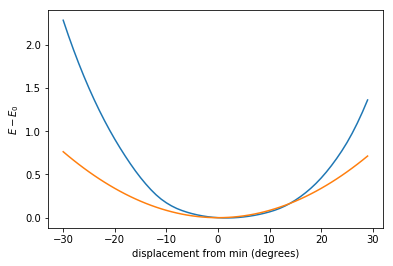

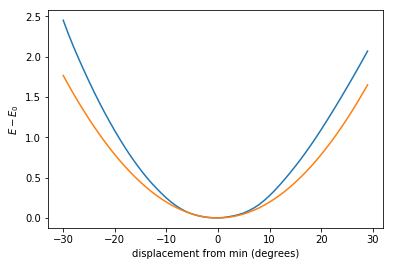

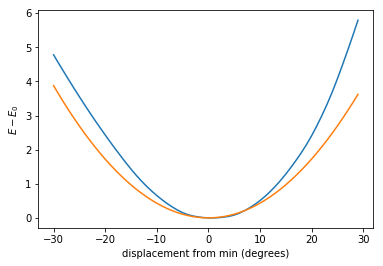

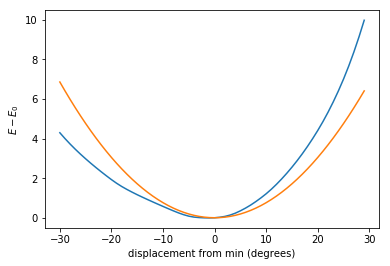

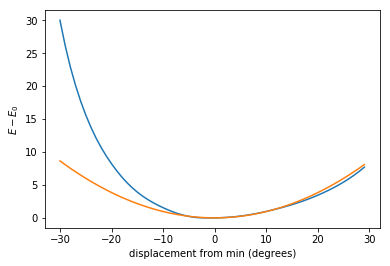

In [104]:
for kk in range(1,6):
    
    K = w[kk]
    mode = v[:,kk]
    observer = AddPyMOLObserver(pose, True)
    h = np.arange(-30,30,1)
    h_plot = h*np.pi/180
    #h = np.concatenate((np.append(h, 15), h[: :-1]))

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            pose.set_torsion(dof_dict[jj], dof)

        bar.append(scorefxn(pose)-E_0)
        #print E_0, scorefxn(pose)

    np.array(bar) 
    
    plt.figure()
    plt.plot(h, bar)
    plt.plot(h, 0.5*K*h**2)
    plt.xlabel('displacement from min (degrees)')
    plt.ylabel('$E-E_0$')

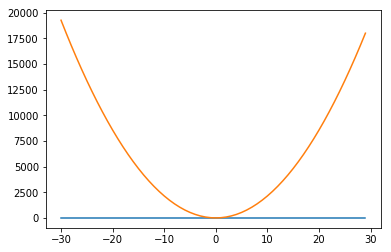

In [68]:

plt.plot(h, bar)
plt.plot(h, K*(h)**2)

In [77]:
from scipy.special import *

Z = 1

for kk in w:
    
    if kk < 0: 
        
        continue 
        
    Z *= np.sqrt(2.0*2.0*np.pi/kk)*erf(np.pi/3.0/np.sqrt(2.0*2.0/kk))
    print Z

2.09407046999
4.38423745437
9.17510419285
19.1895509669
40.1200286185
83.7885861362
174.856807163
364.163994188
752.218433788
1459.20932066
2698.04832523
4786.48000314
3700.51380572
2834.5005941
2170.86775994
1662.60922328
1273.34768167
975.222737679


In [78]:
print -np.log(Z)


-6.88266589381
